In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astra

## Generacja sinogramu z obrazu

### Sinogram koła

In [2]:
def create_circle_phantom(size):
    phantom = np.zeros((size, size), dtype=np.float32)
    rr, cc = np.ogrid[:size, :size]
    center = size / 2
    mask = (rr - center) ** 2 + (cc - center) ** 2 < (size / 4) ** 2
    phantom[mask] = 1.0
    return phantom

In [3]:
def create_phantom_sinogram(phantom, num_angles, img_size, plot=True):
    # Tworzenie geometrii projekcji (równoległa wiązka)
    angles = np.linspace(0, np.pi, num_angles, endpoint=False)
    proj_geom = astra.create_proj_geom("parallel", 1.0, img_size, angles)

    # Tworzenie obiektu danych i geometrii obrazu
    vol_geom = astra.create_vol_geom(img_size, img_size)

    # Generowanie sinogramu (projekcji) — operator forward
    projector_id = astra.create_projector("linear", proj_geom, vol_geom)
    sinogram_id, sinogram = astra.create_sino(phantom, projector_id)

    # Wizualizacja
    if plot:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.title("Obraz wejściowy")
        plt.imshow(phantom, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Sinogram")
        plt.imshow(sinogram, cmap="gray", aspect="auto")
        plt.xlabel("Pozycja detektora")
        plt.ylabel("Kąt projekcji")
        plt.show()

    # Sprzątanie
    astra.data2d.delete(sinogram_id)
    astra.projector.delete(projector_id)

    return sinogram

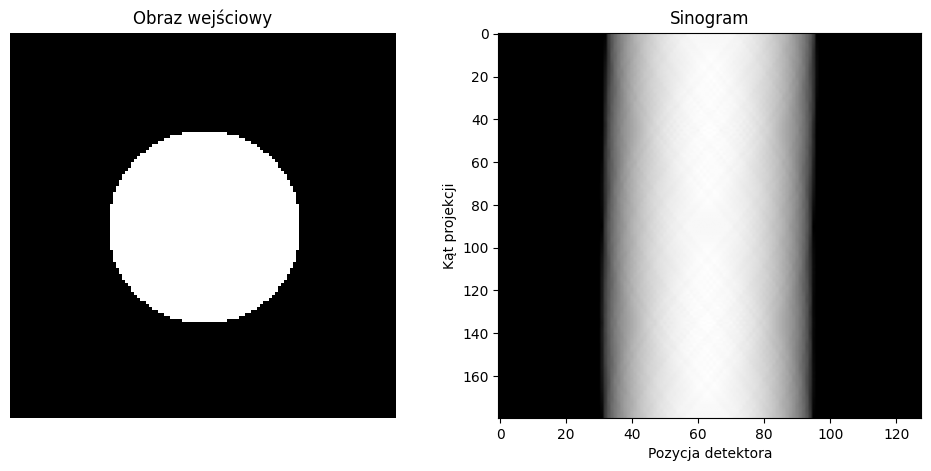

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [4]:
img_size = 128 
num_angles = 180
phantom = create_circle_phantom(img_size)

create_phantom_sinogram(phantom, num_angles, img_size)

### Sinogram punktu

In [5]:
def create_point_phantom(size, point_position):
    phantom = np.zeros((size, size), dtype=np.float32)
    phantom[point_position] = 1.0
    return phantom

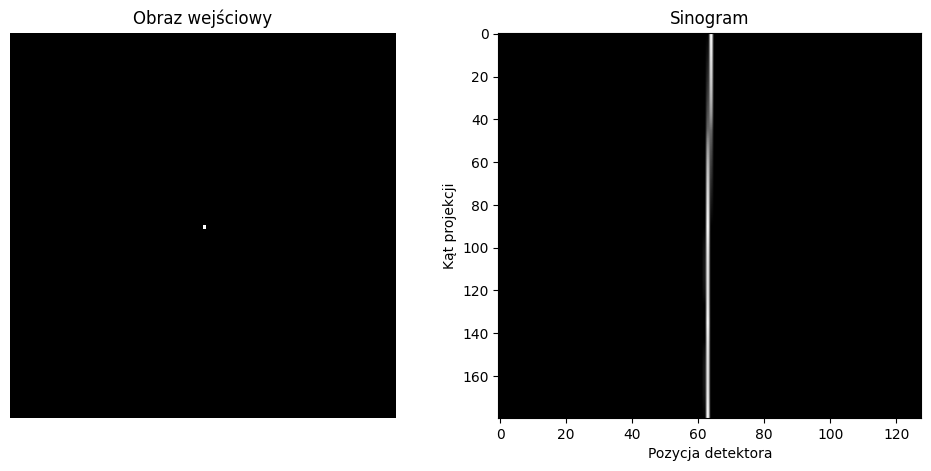

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
img_size = 128
num_angles = 180
point_position = (img_size // 2, img_size // 2)

phantom = create_point_phantom(img_size, point_position)
create_phantom_sinogram(phantom, num_angles, img_size)

Punkt przesunięty względem środka obrazu - widać sinus

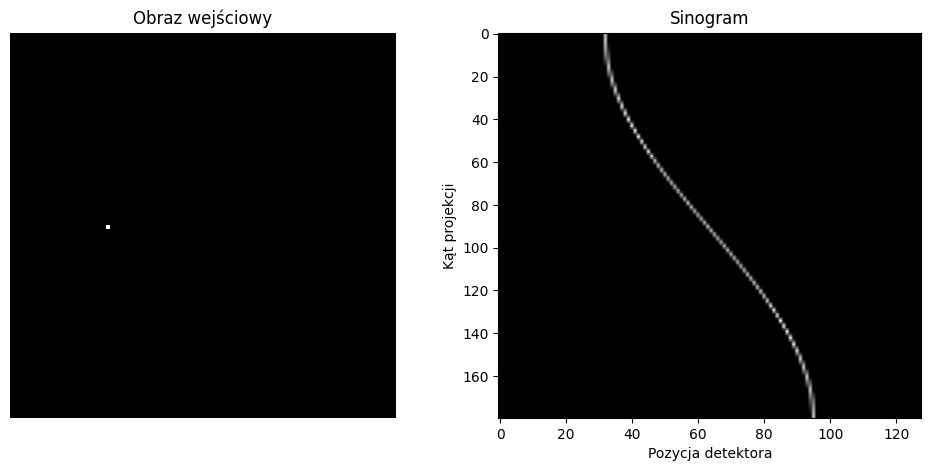

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
point_position = (img_size // 2, int(0.5 * img_size / 2))
phantom = create_point_phantom(img_size, point_position)
create_phantom_sinogram(phantom, num_angles, img_size)

### Sinogram kwadratu

In [8]:
def create_square_phantom(size):
    phantom = np.zeros((size, size), dtype=np.float32)
    phantom[size // 4:size // 4 * 3, size // 4:size // 4 * 3] = 1.0
    return phantom


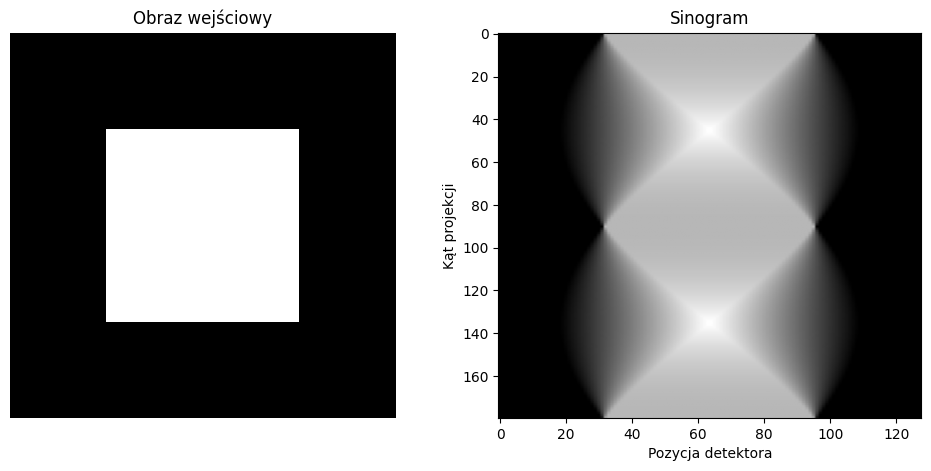

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
img_size = 128
num_angles = 180
phantom = create_square_phantom(img_size)
create_phantom_sinogram(phantom, num_angles, img_size)

### Sinogram prawdziwego obrazu tomograficznego

In [11]:
from PIL import Image

def create_image_phantom(size, filename):
    img = Image.open(filename).convert('L')
    img = img.resize((size, size), Image.Resampling.LANCZOS)
    image = np.array(img, dtype=np.float32) / 255.0

    return image

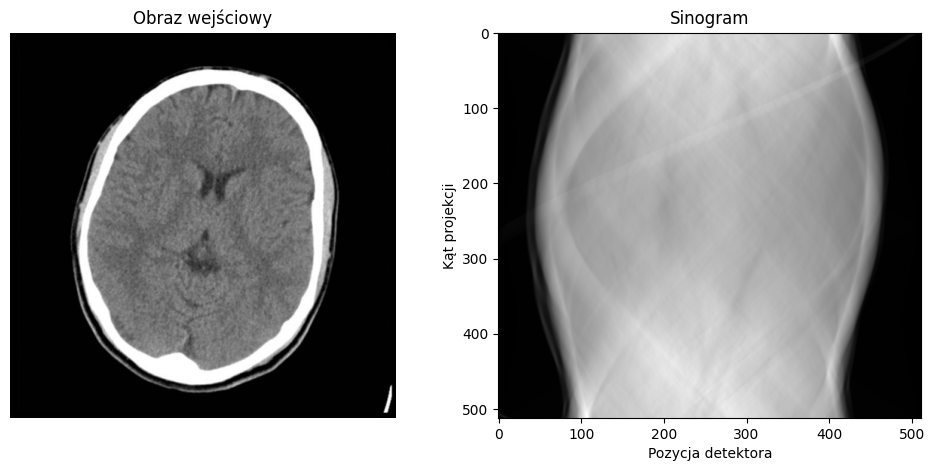

In [14]:
img_size = 512
num_angles = 512
filename = "../../data/images/brain_scanes_ct/ct1.png"

phantom = create_image_phantom(img_size, filename)
img_sinogram = create_phantom_sinogram(phantom, num_angles, img_size)

## Generacja obrazu z sinogramu

In [16]:
def reconstruct_image_from_sinogram(sinogram, num_angles, img_size):
    """
    Rekonstruuje obraz z sinogramu przy użyciu FBP (ASTRA Toolbox).

    Parametry:
        sinogram (ndarray): Sinogram (2D array)
        num_angles (int): Liczba kątów projekcji
        img_size (int): Rozmiar obrazu (np. 256)

    Zwraca:
        ndarray: zrekonstruowany obraz
    """
    # 1. Geometria projekcji (musi być taka sama jak przy tworzeniu sinogramu)
    angles = np.linspace(0, np.pi, num_angles, endpoint=False)
    proj_geom = astra.create_proj_geom('parallel', 1.0, sinogram.shape[1], angles)
    vol_geom = astra.create_vol_geom(img_size, img_size)

    # 2. Konfiguracja danych
    sinogram_id = astra.data2d.create('-sino', proj_geom, sinogram)

    # 3. Konfiguracja algorytmu FBP
    reco_id = astra.data2d.create('-vol', vol_geom)
    cfg = astra.astra_dict('FBP')
    cfg['ReconstructionDataId'] = reco_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = astra.create_projector('linear', proj_geom, vol_geom)

    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)

    # 4. Pobierz wynik
    reconstruction = astra.data2d.get(reco_id)

    # 5. Czyszczenie zasobów
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(reco_id)
    astra.data2d.delete(sinogram_id)

    return reconstruction

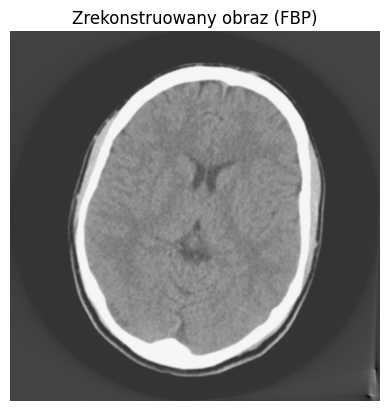

In [19]:
reconstruction = reconstruct_image_from_sinogram(img_sinogram, 512, 512)

plt.imshow(reconstruction, cmap='gray')
plt.title("Zrekonstruowany obraz (FBP)")
plt.axis('off')
plt.show()

### Jakość rekonstrukcji obrazu

In [15]:
def img_diff_mse(imageA: np.ndarray, imageB: np.ndarray):
    """
    Oblicza średni błąd kwadratowy (MSE) między dwoma obrazami.
    """
    if imageA.shape != imageB.shape:
        raise ValueError("Obrazy muszą mieć ten sam rozmiar i kształt")

    err = np.mean((imageA.astype("float") - imageB.astype("float")) ** 2)
    return err

In [16]:
img_phantom = create_image_phantom(512, filename)

errors = []
for i in range(3, 512):
    sinogram = create_phantom_sinogram(img_phantom, i + 1, img_size, plot=False)
    reconstruction = reconstruct_image_from_sinogram(sinogram, i + 1, img_size)
    error = img_diff_mse(reconstruction, img_phantom)
    errors.append(error)

    if (i + 1) % 10 == 0:
        print(f"Angles: {i+1}, error: {error}")

print(f"END ERROR: {errors[-1]}")

Angles: 10, error: 0.1764715636236189
Angles: 20, error: 0.0706810370819619
Angles: 30, error: 0.03999994580788779
Angles: 40, error: 0.026068305792094414
Angles: 50, error: 0.018618062205489803
Angles: 60, error: 0.013876652708443942
Angles: 70, error: 0.010738857138779466
Angles: 80, error: 0.008823019951010633
Angles: 90, error: 0.0072824578699700986
Angles: 100, error: 0.006209958123262392
Angles: 110, error: 0.005365697385088816
Angles: 120, error: 0.0047680220810016865
Angles: 130, error: 0.004300173859625727
Angles: 140, error: 0.003976411764602494
Angles: 150, error: 0.0037197980199669776
Angles: 160, error: 0.0035046610564234337
Angles: 170, error: 0.0033498469727920436
Angles: 180, error: 0.0032345271636073083
Angles: 190, error: 0.003138955753388859
Angles: 200, error: 0.003062684350876639
Angles: 210, error: 0.003000598743066716
Angles: 220, error: 0.0029555373184210693
Angles: 230, error: 0.0029176889748457812
Angles: 240, error: 0.0028896105797291704
Angles: 250, error: 0

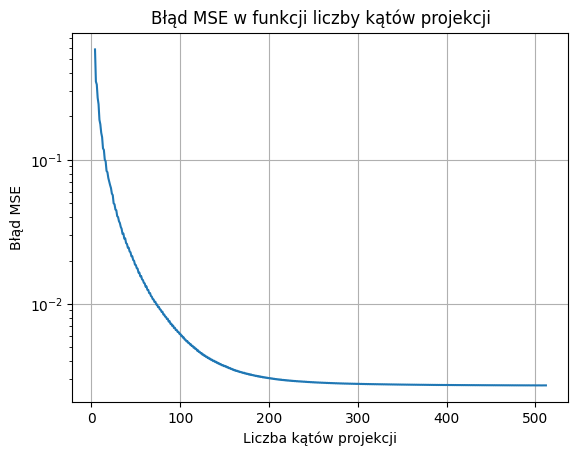

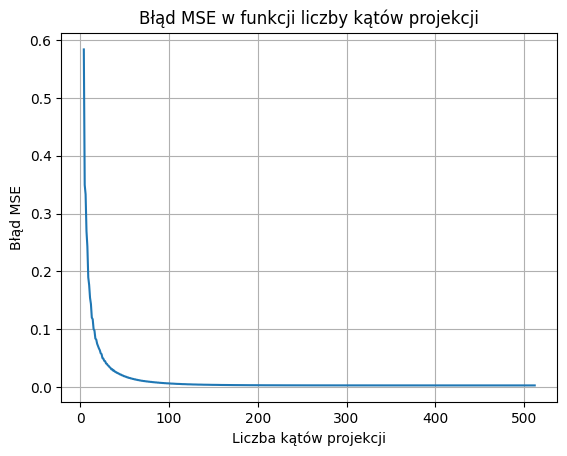

In [17]:
# Plot in log scale
plt.plot(range(4, 513), errors)
plt.title("Błąd MSE w funkcji liczby kątów projekcji")
plt.xlabel("Liczba kątów projekcji")
plt.ylabel("Błąd MSE")
plt.yscale("log")
plt.grid()
plt.show()

# Plot in linear scale
plt.plot(range(4, 513), errors)
plt.title("Błąd MSE w funkcji liczby kątów projekcji")
plt.xlabel("Liczba kątów projekcji")
plt.ylabel("Błąd MSE")
plt.grid()
plt.show()

## Wiązka wachlarzowa

In [18]:
def create_phantom_sinogram_fanflat(phantom, num_angles, img_size, plot=True):
    angles = np.linspace(0, np.pi, num_angles, endpoint=False)

    det_spacing = 1.0
    det_count = img_size
    source_origin = img_size
    origin_det = img_size

    proj_geom = astra.create_proj_geom(
        "fanflat", det_spacing, det_count, angles, source_origin, origin_det
    )

    vol_geom = astra.create_vol_geom(img_size, img_size)

    phantom_id = astra.data2d.create("-vol", vol_geom, phantom)
    sinogram_id = astra.data2d.create("-sino", proj_geom)

    projector_id = astra.create_projector("fanflat", proj_geom, vol_geom)

    cfg = astra.astra_dict("forward")
    cfg["ProjectorId"] = projector_id
    cfg["ProjectionDataId"] = sinogram_id
    cfg["VolumeDataId"] = phantom_id

    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)

    sinogram = astra.data2d.get(sinogram_id)

    # Sprzątanie
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(sinogram_id)
    astra.data2d.delete(phantom_id)
    astra.projector.delete(projector_id)

    if plot:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.title("Obraz wejściowy")
        plt.imshow(phantom, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Sinogram (fanflat)")
        plt.imshow(sinogram, cmap="gray", aspect="auto")
        plt.xlabel("Pozycja detektora")
        plt.ylabel("Kąt projekcji")
        plt.show()

    return sinogram


In [19]:
img_size = 512
num_angles = 512
filename = "../images/ct.jpeg"

phantom = create_image_phantom(img_size, filename)
img_sinogram = create_phantom_sinogram_fanflat(phantom, num_angles, img_size)

AstraError: Unknown Projector2D type

## Generacja sinogramu używając GPU

In [6]:
def create_phantom_sinogram_gpu(phantom, num_angles, img_size, plot=True):
    angles = np.linspace(0, np.pi, num_angles, endpoint=False)
    proj_geom = astra.create_proj_geom("parallel", 1.0, img_size, angles)

    vol_geom = astra.create_vol_geom(img_size, img_size)

    phantom_id = astra.data2d.create("-vol", vol_geom, phantom)
    sinogram_id = astra.data2d.create("-sino", proj_geom)

    cfg = astra.astra_dict('FP_CUDA')
    cfg['ProjectionDataId'] = sinogram_id
    cfg['VolumeDataId'] = phantom_id

    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)

    sinogram = astra.data2d.get(sinogram_id)

    # Sprzątanie
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(sinogram_id)
    astra.data2d.delete(phantom_id)

    if plot:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.title("Obraz wejściowy")
        plt.imshow(phantom, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Sinogram (GPU)")
        plt.imshow(sinogram, cmap="gray", aspect="auto")
        plt.xlabel("Pozycja detektora")
        plt.ylabel("Kąt projekcji")
        plt.show()

    return sinogram

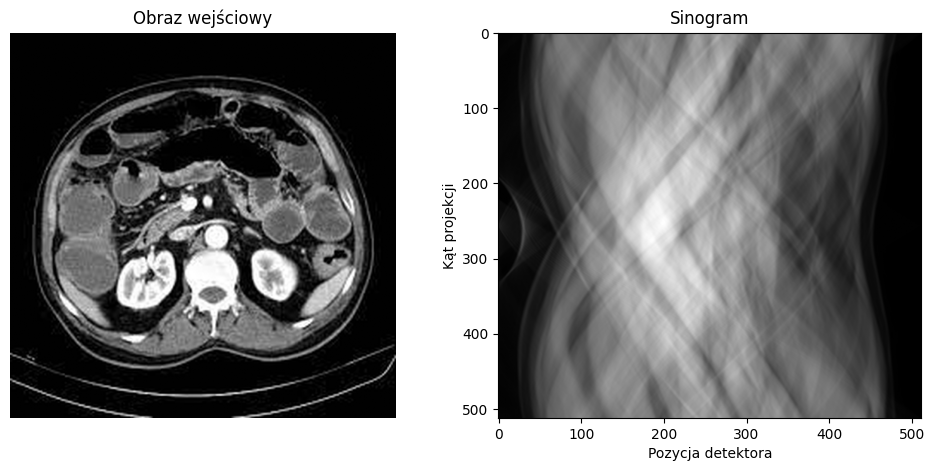

CPU time: 0.9314 seconds


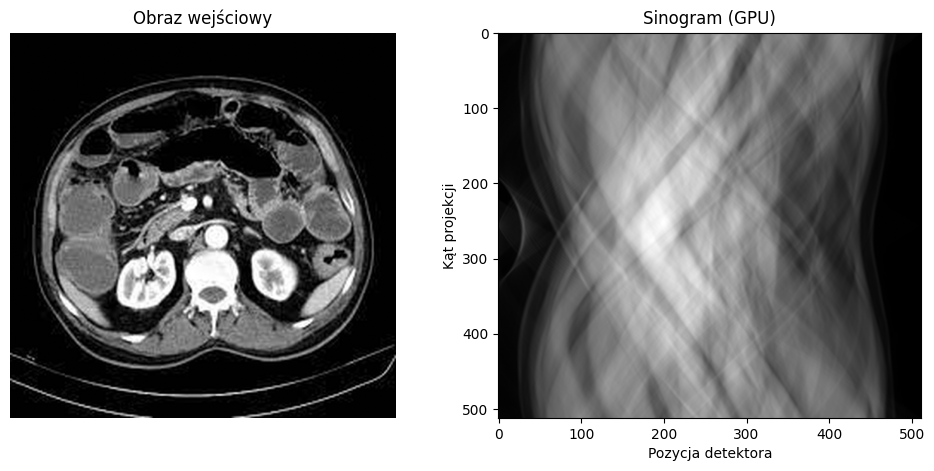

GPU time: 0.2580 seconds


In [13]:
import time

img_size = 512
num_angles = 512
filename = "../../images/ct.jpeg"

phantom = create_image_phantom(img_size, filename)

cpu_start = time.time()
img_sinogram = create_phantom_sinogram(phantom, num_angles, img_size)
cpu_end = time.time()
print(f"CPU time: {cpu_end - cpu_start:.4f} seconds")

gpu_start = time.time()
img_sinogram_gpu = create_phantom_sinogram_gpu(phantom, num_angles, img_size)
gpu_end = time.time()
print(f"GPU time: {gpu_end - gpu_start:.4f} seconds")

Czas na GPU kilka razy krótszy.

In [16]:
error = img_diff_mse(img_sinogram, img_sinogram_gpu)
print(f"Error between CPU and GPU sinograms: {error:.4f}")

Error between CPU and GPU sinograms: 0.0000


Nie ma różnicy pomiędzy obrazami wygenerowanymi używając CPU i GPU, więc ok.